mmsi: 215811000, start_time: 1577904600.0, end_time: 1577906100.0


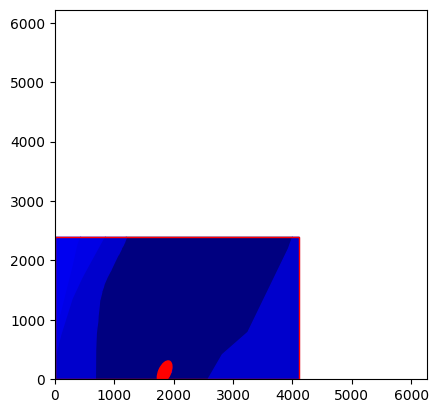

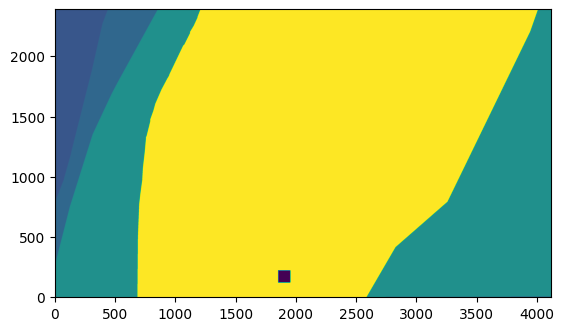

In [90]:
from scm_irl.env.scm_irl_env import ScmIrlEnv
from scm_irl.utils.plot_scenario import plot_cropbox_area
from sllib.conversions.geo_conversions import north_east_to_lat_lon, mps2knots, lat_lon_to_north_east
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from shapely.geometry import box
from shapely.ops import unary_union
from rasterio import features
from shapely.affinity import rotate
from shapely.geometry import Polygon
import matplotlib.patches as patches
import matplotlib.colors as mcolors

from matplotlib.patches import Circle
from matplotlib.patches import Ellipse


env = ScmIrlEnv("/home/rolando/Documents/DTU/SCMarine/ais-and-charts-sample/ais_data/scenario_2a66ceaf61", mmsi=215811000)


d_l_poly = env.scenario.scenario_depth_lands_polygons()

angle = env.agent_state.cog
angle_deg = angle*180/np.pi


# create the croping box
vessel_range_x = 2500
vessel_range_y = 2500

# calculating the value by getting the hipotenuse of the vessel range
crop_box_range_north = np.sqrt(vessel_range_x**2 + vessel_range_y**2)+1000
crop_box_range_east = crop_box_range_north

crop_box_size = (int(crop_box_range_north), int(crop_box_range_east))

crop_box_range_east

# min_e = env.agent_state.lon - vessel_range_x/2
# max_e = env.agent_state.lon + vessel_range_x/2
# min_n = env.agent_state.lat - vessel_range_y/2
# max_n = env.agent_state.lat + vessel_range_y/2

min_e = max([env.agent_state.lon - crop_box_range_north/2, env.scenario.east_min])
max_e = min([env.agent_state.lon + crop_box_range_north/2, env.scenario.east_max])
min_n = max([env.agent_state.lat - crop_box_range_east/2, env.scenario.north_min])
max_n = min([env.agent_state.lat + crop_box_range_east/2, env.scenario.north_max])

# get the new agent location base on the crop box

vessel_location_x = env.agent_state.lon
vessel_location_y = env.agent_state.lat


crop_box = box(min_e, min_n, max_e, max_n)

center_e = (min_e + max_e) / 2
center_n = (min_n + max_n) / 2

#crop_box = rotate(crop_box, angle_deg, origin=(center_e, center_n))

depths_lands_inside = [(polygon.intersection(crop_box), depth) for polygon, depth in d_l_poly if crop_box.intersects(polygon)]

## add a polygon in the center of the vessel
center_polygon = Polygon([(vessel_location_x, vessel_location_y), (vessel_location_x+100, vessel_location_y),
                           (vessel_location_x+100, vessel_location_y+100), (vessel_location_x, vessel_location_y+100)])
depths_lands_inside.append((center_polygon, -10))

plot_cropbox_area(depths_lands_inside, crop_box, env, color='blue')


# Convert to matrix
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import Polygon
from rasterio.transform import from_origin

# Determine the spatial extent of the polygons
min_x, min_y, max_x, max_y = crop_box.bounds

# Determine the resolution of the raster
resolution = 1

# Determine the number of rows and columns of the raster
num_rows = int((max_y - min_y) / resolution)
num_cols = int((max_x - min_x) / resolution)
matrix_size = (num_rows, num_cols)

# Create a transformation matrix
transform = from_origin(min_x, max_y, resolution, resolution)
# Create the matrix
matrix = rasterize(depths_lands_inside, out_shape=(num_rows, num_cols), transform=transform, fill=-1)

#matrix_p = np.array(matrix)

# Plot the matrix
plt.imshow(matrix, cmap='viridis', extent=(min_x, max_x, min_y, max_y))
# Get the coordinates of the crop box
x, y = crop_box.exterior.coords.xy

# Plot the crop box
#plt.plot(x, y, color='red')

# draw the ellipse
ellipse = Ellipse((env.agent_state.lon, env.agent_state.lat), 400, 200, fill=True, color='red', angle=90-(env.agent_state.cog)*180/np.pi)

#plt.gca().add_patch(ellipse)

# Show the plot
plt.show()


In [91]:
matrix[-1,:] = (matrix[-2,:] + matrix[-3,:])/2
matrix[:,-1] = (matrix[:,-2] + matrix[:,-3])/2
matrix[0,:] = (matrix[1,:] + matrix[2,:])/2
matrix[:,0] = (matrix[:,1] + matrix[:,2])/2

In [83]:
crop_box_size

(4535, 4535)

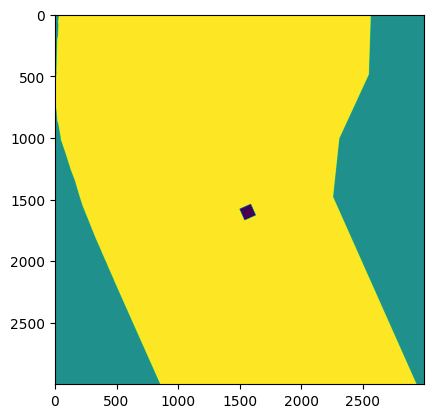

In [95]:
import cv2
import numpy as np

# Convert the rotation center from spatial coordinates to matrix coordinates
rotation_center_spatial = np.array([env.agent_state.lon, env.agent_state.lat])
rotation_center_matrix = np.array([(rotation_center_spatial[0] - min_x) / resolution, 
                                   (max_y - rotation_center_spatial[1]) / resolution])

# Calculate the center of the matrix
center_matrix = np.array([crop_box_size[1] / 2, crop_box_size[0] / 2])

# Calculate the translation needed to move the rotation center to the center of the matrix
translation = center_matrix - rotation_center_matrix

# Define the rotation matrix
M = cv2.getRotationMatrix2D(tuple(center_matrix), angle_deg, 1)

# Add the translation to the rotation matrix
M[0, 2] += translation[0]
M[1, 2] += translation[1]

# Perform the rotation
#rotated_matrix = cv2.warpAffine(matrix, M, crop_box_size)# Perform the rotation
rotated_matrix = cv2.warpAffine(matrix, M, crop_box_size, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

crop_size = (3000, 3000)
top_left = (int(center_matrix[1] - crop_size[0] / 2), int(center_matrix[0] - crop_size[1] / 2))
cropped_matrix = rotated_matrix[top_left[0]:top_left[0]+crop_size[0], top_left[1]:top_left[1]+crop_size[1]]


# Convert the rotation center from matrix coordinates back to spatial coordinates
rotation_center_spatial = np.array([rotation_center_matrix[0] * resolution + min_x, max_y - rotation_center_matrix[1] * resolution])

# Plot the rotated matrix
plt.imshow(cropped_matrix, cmap='viridis')

circle = Circle(rotation_center_matrix, radius=50, color='blue')
#plt.gca().add_patch(circle)

# plot the same ellipse in the new rotated matrix
ellipse = Ellipse(rotation_center_spatial, 200, 400, fill=True, color='red')

#plt.gca().add_patch(ellipse)

# Show the plot
plt.show()

In [73]:
cropped_matrix.shape

(1622, 3000)

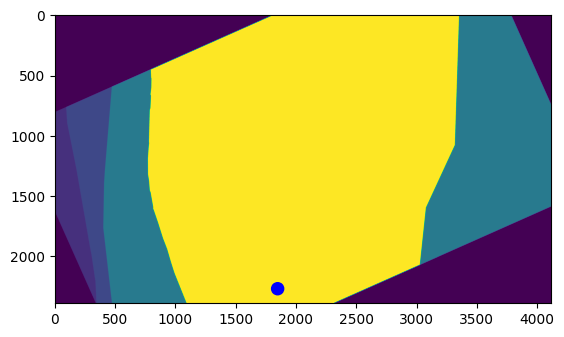

In [57]:
from scipy.ndimage import rotate

# Convert the rotation center from spatial coordinates to matrix coordinates
rotation_center_spatial = np.array([env.agent_state.lon, env.agent_state.lat])
rotation_center_matrix = np.array([(rotation_center_spatial[0] - min_x) / resolution, 
                                   (max_y - rotation_center_spatial[1]) / resolution])
            

# Perform the rotation
rotated_matrix = rotate(matrix, angle_deg, reshape=False, order=1, mode='constant', cval=-1, prefilter=True)

# Convert the rotation center from matrix coordinates back to spatial coordinates
rotation_center_spatial = np.array([rotation_center_matrix[0] * resolution + min_x, max_y - rotation_center_matrix[1] * resolution])

# Plot the rotated matrix
plt.imshow(rotated_matrix, cmap='viridis')

circle = Circle(rotation_center_matrix, radius=50, color='blue')
plt.gca().add_patch(circle)

# plot the same ellipse in the new rotated matrix
ellipse = Ellipse(rotation_center_matrix, 200, 400, fill=True, color='red')

#plt.gca().add_patch(ellipse)

# Show the plot
plt.show()


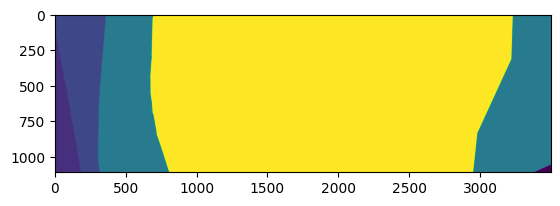

In [34]:
# Define the size of the rectangle to be cropped
crop_size = np.array([3500, 3500])

# Calculate the corner coordinates of the rectangle in matrix coordinates
crop_min_matrix = rotation_center_matrix - crop_size / 2
crop_max_matrix = rotation_center_matrix + crop_size / 2

# Convert the corner coordinates to spatial coordinates
crop_min_spatial = crop_min_matrix * resolution + np.array([min_x, min_y])
crop_max_spatial = crop_max_matrix * resolution + np.array([min_x, min_y])

# Crop the rotated matrix using the corner coordinates
cropped_matrix = rotated_matrix[int(crop_min_matrix[1]):int(crop_max_matrix[1]), int(crop_min_matrix[0]):int(crop_max_matrix[0])]

# Plot the cropped matrix
plt.imshow(cropped_matrix, cmap='viridis')


In [4]:
matrix[-1,:] = (matrix[-2,:] + matrix[-3,:])/2
matrix[:,-1] = (matrix[:,-2] + matrix[:,-3])/2
matrix[0,:] = (matrix[1,:] + matrix[2,:])/2
matrix[:,0] = (matrix[:,1] + matrix[:,2])/2

In [28]:
import numpy as np
from scipy.ndimage import map_coordinates


def extract_rotated_submatrix(matrix, center, size, angle):
    # Create a rotation matrix
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

    # Create a grid of coordinates for the sub-matrix
    y, x = np.mgrid[0:size[0], 0:size[1]]
    coords = np.array([y - size[0] / 2, x - size[1] / 2])

    # Rotate the grid of coordinates
    rotated_coords = np.tensordot(rotation_matrix, coords, axes=1)

    # Translate the rotated grid of coordinates
    translated_coords = rotated_coords + np.array(center).reshape(2, 1, 1)

    # Interpolate the values of the main matrix at the coordinates of the translated grid
    sub_matrix = map_coordinates(matrix, translated_coords, order=1)

    # Calculate the minimum and maximum coordinates of the submatrix
    min_coords = center - np.array(size) / 2
    max_coords = center + np.array(size) / 2

    return sub_matrix, min_coords, max_coords


# Define the center, size, and rotation angle of the sub-matrix
#center = (matrix_size[0]/2, matrix_size[1]/2)
center = (vessel_location_y, vessel_location_x)
# center = (100, 100)
size = (vessel_range_x, vessel_range_y)
#size = matrix_size
angle = np.radians(-angle_deg)*0

# Extract the rotated submatrix and its coordinates
sub_matrix, min_coords, max_coords = extract_rotated_submatrix(matrix, center, size, angle)

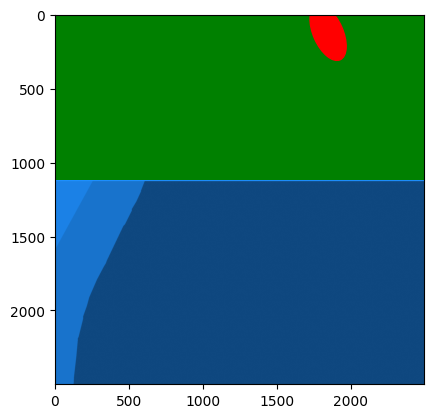

In [29]:
from matplotlib.colors import LinearSegmentedColormap

color = 'dodgerblue'
#color = 'royalblue'
modulated_color = modulate_color(color, 1)

colors = [(0, "green")]
for i in range(1, 256):
    colors.append((i/255, modulate_color(color, 1-i/255)))

cmap = LinearSegmentedColormap.from_list('custom', colors)


# Plot the normalized matrix
plt.imshow(sub_matrix/100, cmap=cmap, vmin=0, vmax=1)

# draw the ellipse
ellipse = Ellipse((vessel_location_x, vessel_location_y), 400, 200, fill=True, color='red', angle=90-(env.agent_state.cog)*180/np.pi)

plt.gca().add_patch(ellipse)

# Show the plot
plt.show()

# TEST

In [6]:
from scm_irl.env.scm_irl_env import ScmIrlEnv
from scm_irl.utils.plot_scenario import plot_cropbox_area, modulate_color, cmap_seachart

import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse

mmsi: 215811000, start_time: 1577904600.0, end_time: 1577906100.0


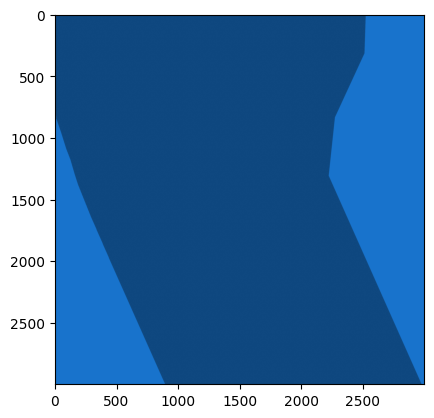

In [7]:
env = ScmIrlEnv("/home/rolando/Documents/DTU/SCMarine/ais-and-charts-sample/ais_data/scenario_2a66ceaf61", mmsi=215811000)


matrix = env._get_observation_matrix()


cmap = cmap_seachart()


# Plot the normalized matrix
plt.imshow(matrix/100, cmap=cmap, vmin=0, vmax=1)

# draw the ellipse
#ellipse = Ellipse((vessel_location_x, vessel_location_y), 200, 400, fill=True, color='red', angle=90-(env.agent_state.cog)*180/np.pi)

#plt.gca().add_patch(ellipse)

# Show the plot
plt.show()